# ¿Podemos predecir si un cliente se suscribira a un deposito a plazo?

## Introduccion

**Contexto comercial.** Ha habido una disminución de ingresos en el Banco Portugués y les gustaría saber qué acciones tomar. Después de la investigación, descubrieron que la causa raíz era que sus clientes no estaban invirtiendo lo suficiente en depósitos a largo plazo. Por lo tanto, al banco le gustaría identificar a los clientes existentes que tienen una mayor probabilidad de suscribirse a un depósito a largo plazo y centrar los esfuerzos de marketing en dichos clientes.

**Problema comercial.** ¿Determinar cuales son los grupos de personas con mas posibilidad de suscribirá (sí/no) un depósito a plazo ?

**Contexto analitico.** Los datos están relacionados con campañas de marketing directo de una institución bancaria portuguesa. Las campañas de marketing se basaron en llamadas telefónicas. Muchas veces se requería más de un contacto con el mismo cliente, para poder acceder si el producto (depósito bancario a plazo) estaría suscrito ('sí') o no ('no') suscrito.

Hay dos conjuntos de datos: train.csv con todos los ejemplos (32950) y 21 entradas que incluyen la función de destino, ordenadas por fecha (de mayo de 2008 a noviembre de 2010), muy cerca de los datos analizados en [Moro et al., 2014]

test.csv que son los datos de prueba que consisten en 8238 observaciones y 20 características sin la característica de destino

## Exploracion de datos 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn 
import plotly.express as px
from scipy.stats import norm

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score,accuracy_score, classification_report , roc_auc_score,confusion_matrix,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split

In [ ]:
entrenamiento = pd.read_csv("new_train.csv")
#eliminacion de duplicados
entrenamiento.duplicated().sum()
entrenamiento.drop_duplicates(inplace = True)
entrenamiento.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [ ]:
entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32942 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32942 non-null  int64 
 1   job          32942 non-null  object
 2   marital      32942 non-null  object
 3   education    32942 non-null  object
 4   default      32942 non-null  object
 5   housing      32942 non-null  object
 6   loan         32942 non-null  object
 7   contact      32942 non-null  object
 8   month        32942 non-null  object
 9   day_of_week  32942 non-null  object
 10  duration     32942 non-null  int64 
 11  campaign     32942 non-null  int64 
 12  pdays        32942 non-null  int64 
 13  previous     32942 non-null  int64 
 14  poutcome     32942 non-null  object
 15  y            32942 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.3+ MB


In [ ]:
entrenamiento.mean()

<ipython-input-4-f0baa889b895>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  entrenamiento.mean()


age          40.012810
duration    258.159614
campaign      2.560804
pdays       962.043440
previous      0.174762
dtype: float64

Preguntas de hipotesis

*   Que grupos de edad son los mas propensos a tomar un deposito a plazo.
Tomando en cuenta una agrupacion por rangos de edad.
*   Cual es el estado civil con mayor porcentaje en la base.


In [ ]:
rango_edad = []

for i in entrenamiento.age:
    if 10 < i < 20:
        rango_edad.append('10 -20')
    elif 20 < i < 35:
        rango_edad.append ('20-35')
    elif 35 < i < 45:
        rango_edad.append ('35-40')
    elif 40 < i < 55:
        rango_edad.append ('40-55')
    elif 55 < i < 65:
        rango_edad.append ('55-65')
    elif 65 < i < 75:
        rango_edad.append ('65-75')
    elif 75 < i < 85:
        rango_edad.append ('75-85')
    elif 75 < i < 95:
        rango_edad.append ('75-95')
    else:
        rango_edad.append('mayor a 95')

entrenamiento['GrupoEdad'] = rango_edad   

In [ ]:
fig=px.pie(entrenamiento.GrupoEdad ,entrenamiento.GrupoEdad.values, hole = 0.3,title = 'Gráfico de torta por grupo de edades' )
fig.update_layout(width = 600, height = 600)
fig.update_traces(textposition='inside', textinfo='percent+label',textfont_size=13,pull=0.01)
fig.show()

Se puede observar que los grupos mayores son de 35-40, 20-35 y 40-55

In [ ]:
fig=px.pie(entrenamiento.marital,entrenamiento.marital.values, hole = 0.03 , title = 'Estado civil')
fig.update_layout(width = 600, height = 600)
fig.update_traces(textposition='inside', textinfo='percent+label',textfont_size=13,pull=0.01)
fig.show()

Se puede observar que dentro de la base la población de casados es la mayor con respecto a toda la base.

In [ ]:
fig=px.bar(pd.crosstab(entrenamiento.GrupoEdad, entrenamiento.y), barmode= 'group')
fig.update_layout(width = 900)
fig.show()

En base de esta resultado vamos a realizar un analisis de 3 poblaciones, por grupo de edad para determinar entre cada grupo de edades quienes tienen mas porcentaje de exito.

Donde sera enmarcado de la siguiente manera:

*   Poblacion joven edad entre 20 a 40 años.
*   Poblacion Adulto intermedio 40 a 65 años.
*   Poblacion Adulto mayor 65 a 95 años.


In [ ]:
resultado = pd.DataFrame()

In [ ]:
cantidadJoven =0
cantidadSiJoven =0
cantidadNoJoven =0

cantidadAdulto=0
cantidadSiAdulto =0
cantidadNoAdulto =0

cantidadAdultoMayor=0
cantidadSiAdultoMayor =0
cantidadNoAdultoMayor =0

edad1 =""
edad2 =""
edad3 =""

for i in range(20,95):
    if 20 < i < 40:
      res = entrenamiento[entrenamiento["age"]==i]
      cantidadJoven = cantidadJoven + res.age.count()      
      cantidadSiJoven = cantidadSiJoven + res[res["y"]=="yes" ].y.count()
      cantidadNoJoven = cantidadNoJoven + res[res["y"]=="no" ].y.count()     
    elif 40 < i < 65:
      res = entrenamiento[entrenamiento["age"]==i]
      cantidadAdulto = cantidadAdulto + res.age.count()      
      cantidadSiAdulto = cantidadSiAdulto + res[res["y"]=="yes" ].y.count()
      cantidadNoAdulto = cantidadNoAdulto + res[res["y"]=="no" ].y.count()       
    elif 65 < i < 95:
      res = entrenamiento[entrenamiento["age"]==i]
      cantidadAdultoMayor = cantidadAdultoMayor + res.age.count()      
      cantidadSiAdultoMayor = cantidadSiAdultoMayor + res[res["y"]=="yes" ].y.count()
      cantidadNoAdultoMayor = cantidadNoAdultoMayor + res[res["y"]=="no" ].y.count()        

total = cantidadJoven + cantidadAdulto + cantidadNoAdultoMayor

item = {"edad":"Joven","poblacion":cantidadJoven,"poblacionTotal":total,"si":cantidadSiJoven,"no":cantidadNoJoven,"porcentajeAprobacionPorEdad":(cantidadSiJoven*100)/cantidadJoven,"porcentajeAprobacionTotal":(cantidadSiJoven*100)/total }        
resultado = resultado.append(item,ignore_index=True)   

item = {"edad":"Adulto","poblacion":cantidadAdulto,"poblacionTotal":total,"si":cantidadSiAdulto,"no":cantidadNoAdulto,"porcentajeAprobacionPorEdad":(cantidadSiAdulto*100)/cantidadAdulto,"porcentajeAprobacionTotal":(cantidadSiAdulto*100)/total}        
resultado = resultado.append(item,ignore_index=True)   

item = {"edad":"Adulto Mayor","poblacion":cantidadAdultoMayor,"poblacionTotal":total,"si":cantidadSiAdultoMayor,"no":cantidadNoAdultoMayor,"porcentajeAprobacionPorEdad":(cantidadSiAdultoMayor*100)/cantidadAdultoMayor,"porcentajeAprobacionTotal":(cantidadSiAdultoMayor*100)/total}        
resultado = resultado.append(item,ignore_index=True) 

<ipython-input-10-0a8acc62da67>:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-10-0a8acc62da67>:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-10-0a8acc62da67>:43: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
 resultado 

,edad,poblacion,poblacionTotal,si,no,porcentajeAprobacionPorEdad,porcentajeAprobacionTotal
0,Joven,17942,31615,2067,15875,11.520455,6.538036
1,Adulto,13414,31615,1285,12129,9.579544,4.064526
2,Adulto Mayor,488,31615,229,259,46.926230,0.724340


De los datos calculados se pueden obtener varios resultados:

1. La población total es de 31356.0.
2. La población total de jóvenes es de 17942.
3. La población total de adultos es de 13414.
4. El total de ambas poblaciones es de 31356.
5. El porcentaje de éxito de la población joven con respecto a toda su población 11.52%.
6. El porcentaje de éxito de la población adulta con respecto a toda su población 9.57%.
7. El porcentaje de éxito de la población joven con respecto a la población total 6.59%
8. El porcentaje de éxito de la población adulta con respecto a la población total 4.09%.
9. El porcentaje de exito dentro de la poblacion adulto mayor es de 46.92 sin embargo por respecto a la base total es de 0.72%.



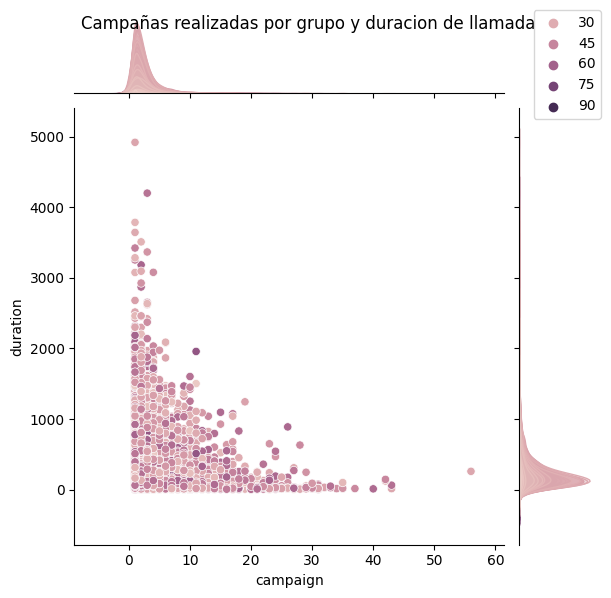

In [ ]:
p = sns.jointplot(data=entrenamiento, x="campaign", y="duration", hue='age')
p.fig.suptitle("Campañas realizadas por grupo y duracion de llamada")
p.ax_joint.legend_._visible=False 
p.fig.legend(bbox_to_anchor=(1, 1), loc=1)

##**Matrices de correlacion**

In [ ]:
matrix_correlation = entrenamiento.corr() #corr pearson por default
matrix_correlation.head()

,age,duration,campaign,pdays,previous
age,1.000000,-0.001742,0.003376,-0.032042,0.020717
duration,-0.001742,1.000000,-0.075726,-0.047105,0.022496
campaign,0.003376,-0.075726,1.000000,0.053811,-0.079079
pdays,-0.032042,-0.047105,0.053811,1.000000,-0.589596
previous,0.020717,0.022496,-0.079079,-0.589596,1.000000


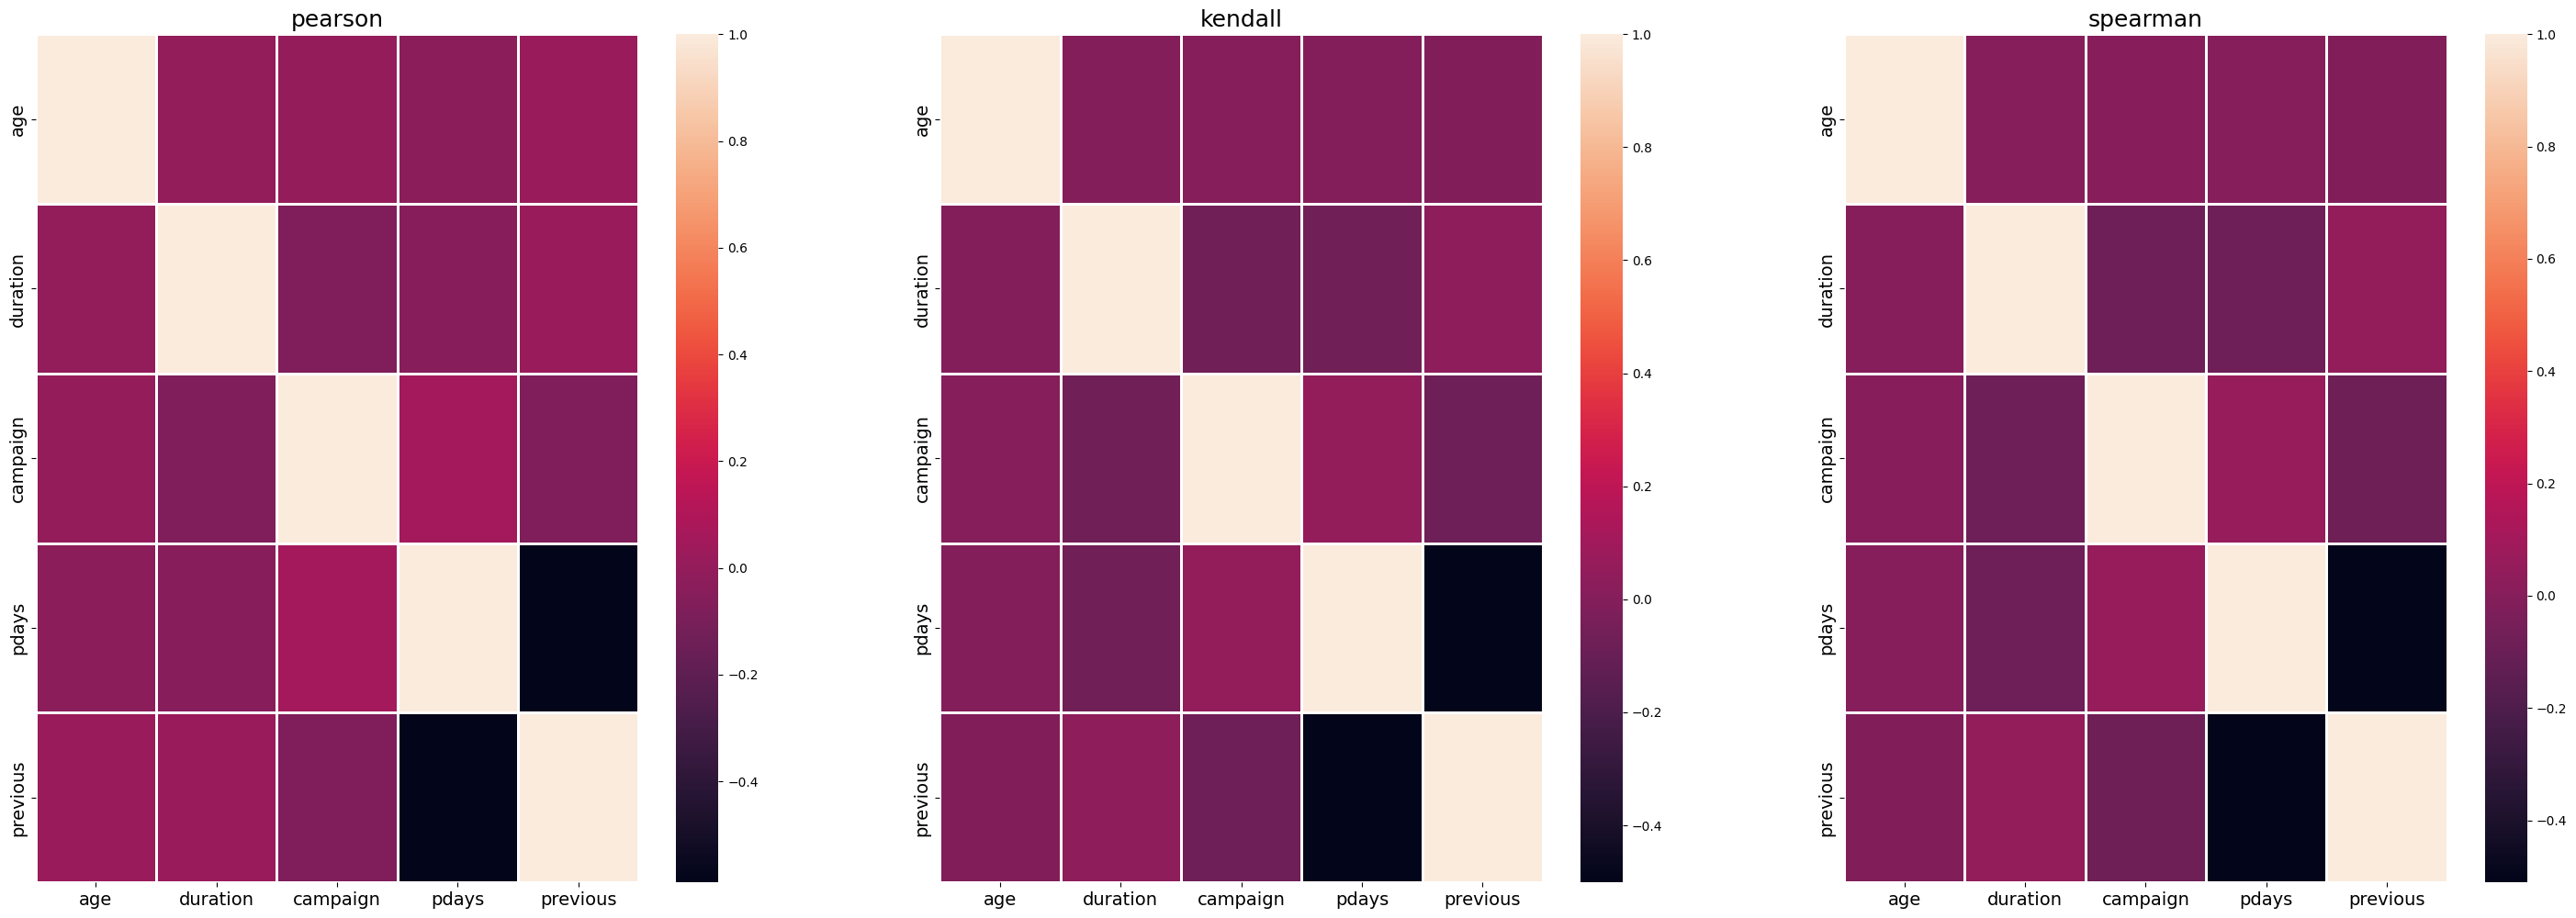

In [ ]:
#generacion de los graficos de correlacion entre los 3 metodos, 
plt.figure(figsize=(36,12))
for j,i in enumerate(['pearson','kendall','spearman']):
  plt.subplot(1,3,j+1)
  correlation = entrenamiento.dropna().corr(method=i)
  sns.heatmap(correlation, linewidth = 2)
  plt.title(i, fontsize=18)
  plt.yticks(fontsize=14)
  plt.xticks(fontsize=14)

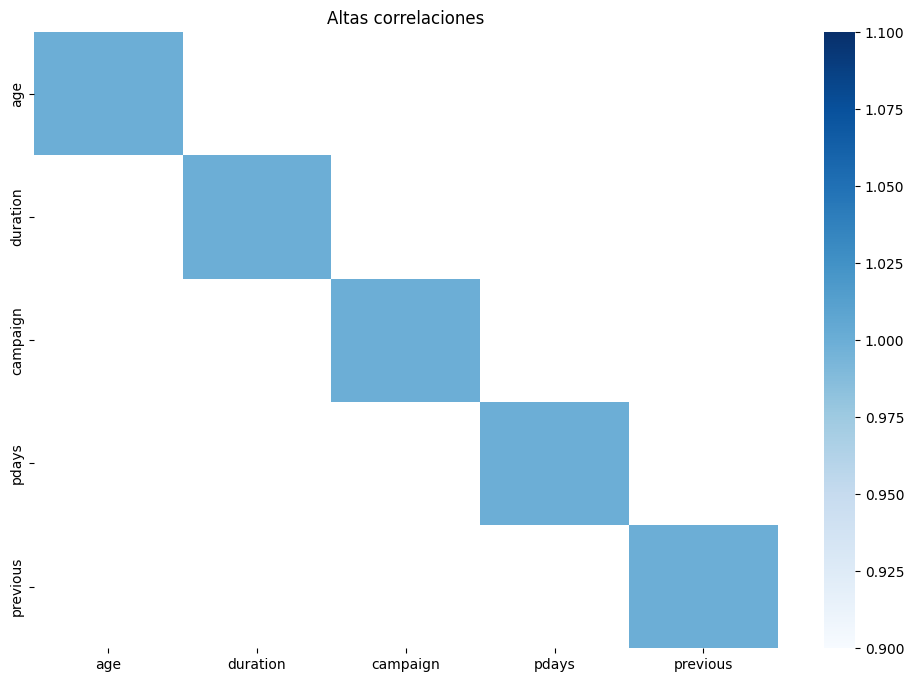

In [ ]:
mat_corr_spearman = entrenamiento.corr('spearman')

high_corr = mat_corr_spearman[mat_corr_spearman>=.8]
plt.figure(figsize=(12,8))
sns.heatmap(high_corr, cmap="Blues")
plt.title('Altas correlaciones');

##**Evaluacion de modelos**

In [ ]:
column_names = ["Metodo","Accuracy","Precision","Recall","ROCAUC"]
result_df =pd.DataFrame(columns = column_names)  


def matrizConfusion(y_test,ypreds):
  fig ,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,4))
  conf = confusion_matrix(y_test, ypreds) 
  sns.heatmap(conf, 
            xticklabels=('no (P)','yes (P)'),
            yticklabels=('no','yes'),
            annot=True,
            fmt="d",
            ax = ax,
            square=1,linewidth=1)

  plt.suptitle('Matriz de confusion')
  plt.ylabel('Clase Verdadera')
  plt.xlabel('Prediccion')
  plt.show()

def guardaDatos(metodo,y_test, y_pred,caluloCompleto,label):
  resultados ={}
  resultados["Metodo"] = metodo
  resultados["Accuracy"] = metrics.accuracy_score(y_test, y_pred)  
 
  if caluloCompleto:        
    resultados["Recall"] =metrics.recall_score(y_test, y_pred,pos_label=label)
    resultados["Precision"] =metrics.precision_score(y_test, y_pred,zero_division=1,pos_label=label)
   
  return resultados

##Regresion logistica

In [ ]:
#selccion de campo a utilizar
X = entrenamiento.iloc[:,[0,1,2,3,4,5,6,11,13,14]]
y = entrenamiento.y
#separa los campo texto
X_cat = list(X.select_dtypes(exclude = 'int').columns)  
#separa los campo con numerico
X_num = list(X.select_dtypes(exclude = 'object').columns)  
#Ordena el dataset en texto y luego numero
X = entrenamiento[X_cat + X_num]

#creacion del objecto model
X_cat_pipe = Pipeline ( [ ('OneHotEncoder', OneHotEncoder(handle_unknown= 'ignore'))])
X_num_pipe = Pipeline( [ ('sc', StandardScaler())])
transformer = ColumnTransformer([("X_cat_pipe", X_cat_pipe,X_cat ),("X_num_pipe",X_num_pipe,X_num)],remainder='drop')
model = Pipeline ( [ ('transformer', transformer),('lgr', LogisticRegression(random_state=42, max_iter=3000)),])
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size= 0.3, random_state= 42)
model.fit(X_train, y_train)
ypreds = model.predict(X_test)

In [ ]:
result_df = result_df.append(guardaDatos('Regresion logistica',y_test, ypreds,False,""),ignore_index=True)

<ipython-input-18-a73586a494d3>:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



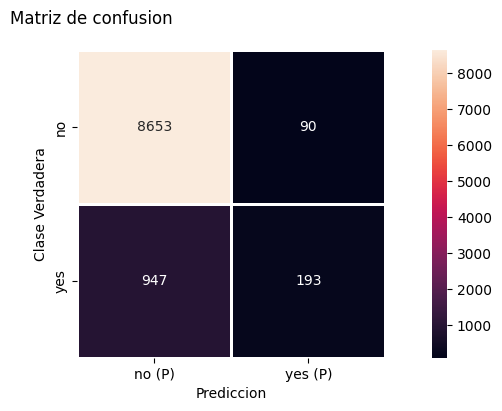

In [ ]:
matrizConfusion(y_test,ypreds)

##Decision Tree

<ipython-input-20-2ba0c73ddf8f>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-20-2ba0c73ddf8f>:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



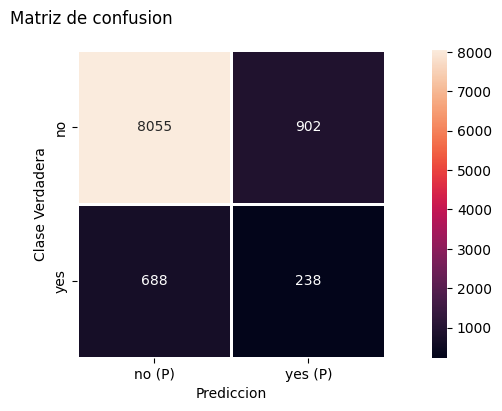

In [ ]:
#Separamos en train y test!
modelDecisionTree = Pipeline ( [ ('transformer', transformer),('lgr', DecisionTreeClassifier(random_state=42)),]) 
modelDecisionTree.fit(X_train, y_train)
y_test_pred = modelDecisionTree.predict(X_test) #Prediccion en Test
result_df = result_df.append(guardaDatos('Decision Tree - label yes',y_test, y_test_pred,True,"yes"),ignore_index=True)
result_df = result_df.append(guardaDatos('Decision Tree - label no',y_test, y_test_pred,True,"no"),ignore_index=True)
matrizConfusion(y_test_pred, y_test)

Crear la Matriz de Confusión

In [ ]:
result_df

,Metodo,Accuracy,Precision,Recall,ROCAUC
0,Regresion logistica,0.895072,NaN,NaN,NaN
1,Decision Tree - label yes,0.839118,0.257019,0.208772,NaN
2,Decision Tree - label no,0.839118,0.899297,0.921308,NaN


##Conclusión

Se selecciona el algoritmo de Regresion logistica ya que su accuracy es de 0.89